test_result:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2]


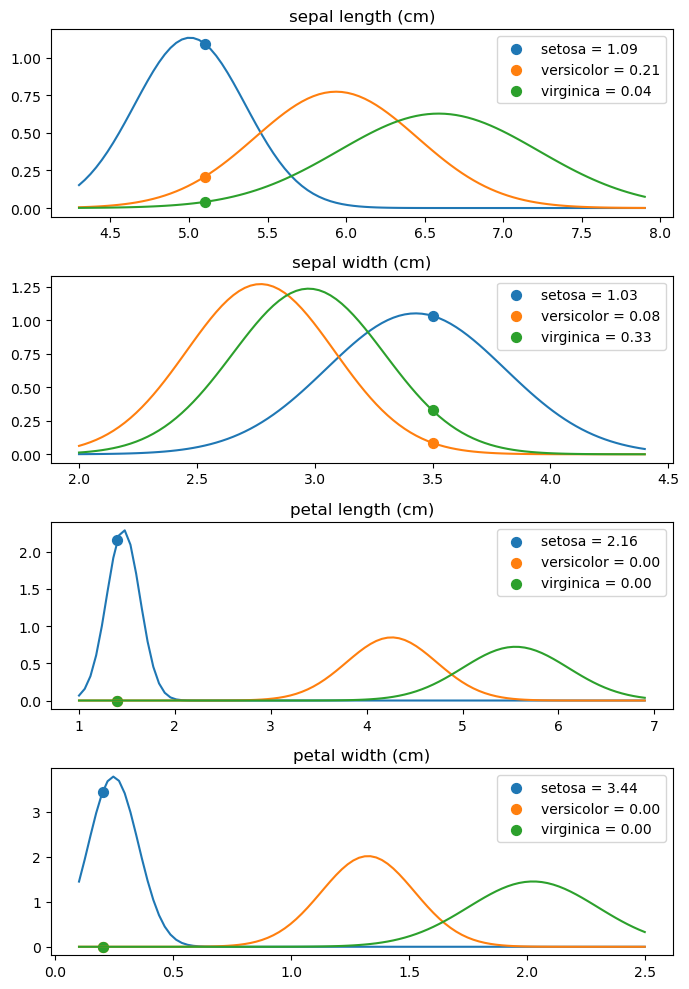

In [120]:
from typing import Iterable
import pandas as pd
import numpy as np
import math
from sklearn.datasets import load_iris
from functools import reduce
import matplotlib.pyplot as plt

data_iris = load_iris()
feature_names = data_iris.feature_names

def probability_density(value: float, mean: float, std: float) -> float:
    exponent = -( ((value - mean) ** 2) / (2 * (std ** 2)) )
    denominator: float = math.sqrt(2 * np.pi * (std ** 2))
    return ( 1 / denominator ) * math.exp(exponent)

def gaussian_naive_bayes(gaussian_constants: Iterable[Iterable[tuple[float,float]]], hypothesis_idx: int, data: Iterable[float]) -> float:
    hypothesis_likelihoods = gaussian_constants[hypothesis_idx]
    data_likelihoods: list[float] = [
        probability_density(value=data[idx_feature], mean=mean, std=std) 
        for idx_feature, (mean, std) in enumerate(hypothesis_likelihoods) 
    ]
    return reduce(lambda acc, x: acc * x, data_likelihoods, 1)
        
df_data_iris = pd.DataFrame(data_iris.data)
targets = pd.Series(data_iris.target)
hypotheses = targets.unique()
hypotheses.sort()
indices_by_target = [ targets == target_value for target_value in hypotheses ]
gaussian_constants_feature_of_hypothesis = [[] for _ in hypotheses]
for (idx_target, indices) in enumerate(indices_by_target):
    for (idx_feature, name) in enumerate(feature_names):
        data_feature_in_hypothesis = df_data_iris[indices][idx_feature]
        mean = data_feature_in_hypothesis.mean(axis=0)
        std = data_feature_in_hypothesis.std(axis=0)
        gaussian_constants_feature_of_hypothesis[idx_target].append((mean, std))

test_data_set = [ df_data_iris.iloc[i] for i in range(90, 110) ]
test_result = []
for test_data in test_data_set:
    hypothesis_posteriors = [ 
        (hypothesis, gaussian_naive_bayes(gaussian_constants=gaussian_constants_feature_of_hypothesis,
                                            hypothesis_idx=idx_hypothesis, 
                                            data=test_data))
        for (idx_hypothesis, hypothesis) in enumerate(hypotheses)
    ]
    max_hypothesis, max_posterior = hypothesis_posteriors[0]
    for (hypothesis, posterior) in hypothesis_posteriors:
        if posterior > max_posterior:
            max_hypothesis = hypothesis
            max_posterior = posterior
    test_result.append(max_hypothesis)

print(f"test_result:\n{test_result}")

fig, axes = plt.subplots(figsize=(7, 10), nrows=len(feature_names), ncols=1)
gaussian_constants_feature = list(zip(*gaussian_constants_feature_of_hypothesis))
for (idx_feature, name) in enumerate(feature_names):
    data_feature_in_hypothesis = df_data_iris.iloc[:][idx_feature]
    min = data_feature_in_hypothesis.min()
    max = data_feature_in_hypothesis.max()
    test_x = df_data_iris.iloc[0][idx_feature]
    for (idx_target, indices) in enumerate(indices_by_target):
        (mean, std) = gaussian_constants_feature_of_hypothesis[idx_target][idx_feature]
        x = np.linspace(start=min, stop=max, num=100)
        y = [ probability_density(value=_x, mean=mean, std=std) for _x in x ]
        test_y = probability_density(value=test_x, mean=mean, std=std)
        axes[idx_feature].set_title(feature_names[idx_feature])
        axes[idx_feature].scatter(x=test_x, y=test_y, s=50, label=f"{data_iris.target_names[idx_target]} = {test_y:.2f}")
        axes[idx_feature].plot(x, y)
        axes[idx_feature].legend()
        
plt.tight_layout()
plt.show()
